Import Libraries

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..','..','..')))

import pandas as pd, numpy as np, umap, hdbscan
from dec_keras import DEC
from idec import IDEC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.pairwise import rbf_kernel
from keras.optimizers import SGD

1) Load & filter

In [2]:
df = pd.read_csv("../../data/nigerian-songs.csv")
df = df[df['artist_top_genre'].isin(['afro dancehall','afropop','nigerian pop'])]
df = df[df['popularity']>0]
print(df.shape)
df.head()

(286, 16)


,name,album,artist,artist_top_genre,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
1,shuga rush,EVERYTHING YOU HEARD IS TRUE,Odunsi (The Engine),afropop,2020,89488,30,0.710,0.0822,0.683,0.000169,0.1010,-5.640,0.3600,129.993,3
3,Confident / Feeling Cool,Enjoy Your Life,Lady Donli,nigerian pop,2019,175135,14,0.894,0.7980,0.611,0.000187,0.0964,-4.961,0.1130,111.087,4
4,wanted you,rare.,Odunsi (The Engine),afropop,2018,152049,25,0.702,0.1160,0.833,0.910000,0.3480,-6.044,0.0447,105.115,4
5,Kasala,Pioneers,DRB Lasgidi,nigerian pop,2020,184800,26,0.803,0.1270,0.525,0.000007,0.1290,-10.034,0.1970,100.103,4
6,Pull Up,Everything Pretty,prettyboydo,nigerian pop,2018,202648,29,0.818,0.4520,0.587,0.004490,0.5900,-9.840,0.1990,95.842,4


2) Features & scale

In [3]:
audio = ['length','popularity','danceability','acousticness','energy',
         'instrumentalness','liveness','loudness','speechiness','tempo','time_signature']
df['log_pop']=np.log1p(df.popularity); df['sqrt_pop']=np.sqrt(df.popularity)
df['dance_pop']=df.danceability*(df.popularity/100)
X = df[audio+['log_pop','sqrt_pop','dance_pop']].values
X_scaled = StandardScaler().fit_transform(X)



3) UMAP (tuned)

In [4]:
# define best UMAP params (replace with your tuned values)
best_um = {'nn': 15, 'md': 0.1}

# now embed
X_emb = umap.UMAP(n_components=10,n_neighbors=best_um['nn'],min_dist=best_um['md']).fit_transform(X_scaled)


a:\EDUCATION\ML_Starter\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4) HDBSCAN (tuned)

In [5]:
# define best HDBSCAN params (replace with your tuned values)
best = {'mc': 15, 'ms': 5}

hdb = hdbscan.HDBSCAN(min_cluster_size=best['mc'], min_samples=best['ms']).fit(X_emb)
labels_hdb = hdb.labels_


a:\EDUCATION\ML_Starter\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
a:\EDUCATION\ML_Starter\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


5) Spectral on pop-affinity

In [6]:
pop = df.popularity.values.reshape(-1,1)

# Option A: explicit X→X, pop→pop
aff = 0.7 * rbf_kernel(X_scaled, X_scaled, gamma=0.5) + 0.3 * rbf_kernel(pop, pop, gamma=1.0)

# Option B: rely on Y=None default and keyword-only gamma
aff1 = rbf_kernel(X_scaled, gamma=0.5)
aff2 = rbf_kernel(pop,       gamma=1.0)
aff  = 0.7*aff1 + 0.3*aff2

labels_spec = SpectralClustering(n_clusters=3, affinity='precomputed', random_state=42).fit_predict(aff)

6) KMeans (silhouette k)

In [7]:
best_k,best_sil=2,-1
for k in range(2,11):
    l=KMeans(n_clusters=k,random_state=42).fit_predict(X_scaled)
    s=silhouette_score(X_scaled,l)
    if s>best_sil: best_k,best_sil=k,s
labels_km=KMeans(n_clusters=best_k,random_state=42).fit_predict(X_scaled)


7) DEC & IDEC

In [8]:
# --- DEC ---
dec = DEC(
    dims=[X_scaled.shape[1], 500, 500, 2000, 10],
    n_clusters=3
)
# 1. pre‐train the autoencoder
dec.pretrain(X_scaled, epochs=50, batch_size=256)
# 2. compile the clustering model
dec.compile(optimizer=SGD(0.01, 0.9), loss='kld')
# 3. fit + predict in one call
y_dec = dec.fit_predict(X_scaled, tol=1e-3)

# --- IDEC ---
idec = IDEC(dims=[X_scaled.shape[1], 500, 500, 2000, 10], n_clusters=3, alpha=1.0, batch_size=256)
# point IDEC at the pretrained AE weights from DEC
ae_weights_path = 'results/temp/ae_weights.weights.h5'  
idec.initialize_model(ae_weights=ae_weights_path, gamma=0.1, optimizer='adam')
# run the IDEC clustering loop
y_idec = idec.clustering(X_scaled, y=None, tol=1e-3, update_interval=140, maxiter=20000, 
        save_dir='results/idec')


...Pretraining...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 1.0031
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.9720 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.7843 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.7111
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.6106 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.5336
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4602
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3708 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3392 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2967 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2635 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2345 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.2075 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1955 
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1643 
Epo

8) Consensus ensemble

In [9]:
all_lbl = np.vstack([labels_hdb,labels_spec,labels_km,y_dec,y_idec]).T
n=len(df); coassoc=np.zeros((n,n))
for L in all_lbl.T: coassoc += (L[:,None]==L[None,:])
coassoc/=all_lbl.shape[1]
labels_cons = SpectralClustering(n_clusters=3,affinity='precomputed',random_state=42).fit_predict(coassoc)


9) Evaluate & plot

           Silhouette       ARI  Accuracy
HDBSCAN      0.221129 -0.003467  0.374269
Spectral     0.119116 -0.004732  0.346154
KMeans       0.190181 -0.002983  0.118881
DEC          0.168518  0.043437  0.328671
IDEC         0.171333  0.053037  0.206294
Consensus    0.169957  0.048365  0.321678


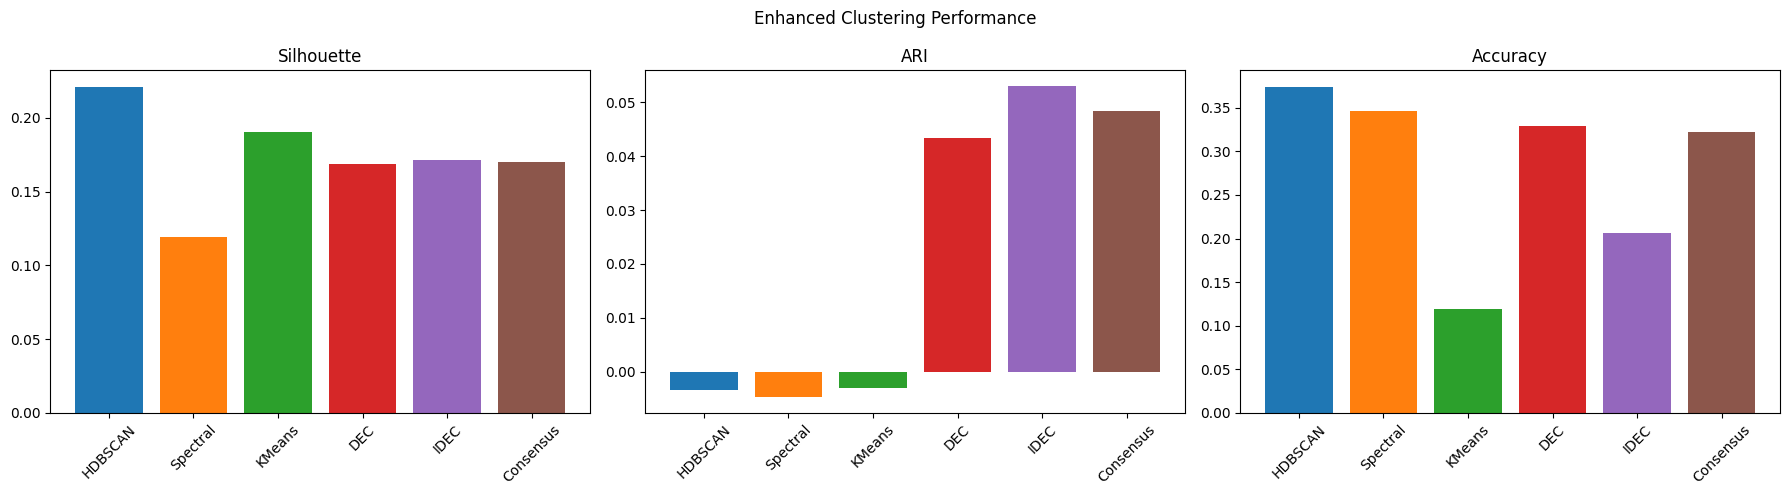

In [10]:
true = df['artist_top_genre'].factorize()[0]
def ev(l): m=l!=-1; return (silhouette_score(X_scaled[m],l[m]),adjusted_rand_score(true[m],l[m]),(true[m]==l[m]).mean())
res={'HDBSCAN':ev(labels_hdb),'Spectral':ev(labels_spec),'KMeans':ev(labels_km),
     'DEC':ev(y_dec),'IDEC':ev(y_idec),'Consensus':ev(labels_cons)}
import pandas as pd; mdf=pd.DataFrame(res,index=['Silhouette','ARI','Accuracy']).T
print(mdf)
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,3,figsize=(18,5))
for i,met in enumerate(mdf.columns):
    ax[i].bar(mdf.index,mdf[met],color=plt.cm.tab10.colors)
    ax[i].set_title(met); ax[i].tick_params(axis='x',rotation=45)
plt.suptitle("Enhanced Clustering Performance"); plt.tight_layout(); plt.show()
